## Receptive Field

In [2]:
# Analysis
import os
import glob
import numpy as np
import pandas as pd
import scipy

# Plotting
import PIL
from PIL import ImageDraw, Image
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

#### 卷积时，filter遍历原图区域的范围和频次

<img src='images/dilation_conv.gif' style="height:150px"></img>

In [3]:
def receptive_field(n=17, f=3, s=1, d=1, p=0):
    img = np.zeros([n,n])
    img = np.pad(img, ((p,p),(p,p))) # padding
    
    f_d = f*d-d+1 #膨胀后的filter size
    rf_filter = np.zeros([f_d,f_d]) #实际filter覆盖原图面积
    for i in range(0,f_d,d):
        for j in range(0,f_d,d):
            rf_filter[i,j]+=1
    
    fm_n = int((n+2*p-f_d)/s+1) #feature map output shape
    for i in range(fm_n): #每个filter点对应区域rf_pre_filter，空洞filter的点是隔开的，相当于用d做stride
            for j in range(fm_n):
                img[i*s:i*s+f_d,j*s:j*s+f_d] += rf_filter 
                
    if p!=0: #把padding再次恢复0
        img[:p,:]=img[-p:,:]=img[:,:p]=img[:,-p:]=0 
    
    plt.figure(figsize=(round((n+2*p)/4,1),round((n+2*p)/4,1)))
    sns.heatmap(img, square=True, cbar=False, linewidth=1, linecolor='black', 
                xticklabels=False, yticklabels=False, cmap='Blues', annot=True)
    plt.title(f'{n}x{n} Input -> {fm_n}x{fm_n} Output\nFilter = {f} (d={d}), p={p}, s={s}')
    plt.show();

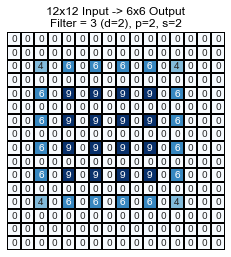

In [4]:
receptive_field(n=12, f=3, s=2, d=2, p=2)

#### 在第L层cov里，1个filter size所对应的原图receptive field

In [5]:
def receptive_field_filter(n=5, f=3, s=1, L=1, d=[1]): # L = len(d)
    img = np.zeros([n,n])
    f_d = f*d[0]-d[0]+1 #膨胀后的filter size
    rf = 1+(f_d-1) #感受野大小
    rf_filter = np.zeros([f_d,f_d]) #感受野实际覆盖原图面积
    for i in range(0,f_d,d[0]):
        for j in range(0,f_d,d[0]):
            rf_filter[i,j]+=1
        
    for l in range(L-1): #遍历每一层
        rf_pre_filter = np.where(rf_filter!=0,1,0) #有遍历过的地方为1，其余为0
        f_d = f*d[l+1]-d[l+1]+1 #从d[1]开始索引，每次都是用原始f来计算当前的f_d
        rf = rf+(f_d-1)*s
        rf_filter = np.zeros([rf,rf]) 
        for i in range(0,f*d[l+1],d[l+1]): #每个filter点对应区域rf_pre_filter，空洞filter的点是隔开的，相当于用d做stride
            for j in range(0,f*d[l+1],d[l+1]):
                rf_filter[i:i+rf_pre_filter.shape[0],j:j+rf_pre_filter.shape[0]] += rf_pre_filter 
        
    # 每个filter点对应的区域叠加
    start = int((n-rf)/2) #对应原始范围第一个始点
    end = start+rf_filter.shape[0] #end为最后一个始点的位置
    img[start:end,start:end] = rf_filter #放在正中间
    
    plt.figure(figsize=(round(n/4,1),round(n/4,1)))
    sns.heatmap(img, square=True, cbar=False, linewidth=1, linecolor='black', 
                xticklabels=False, yticklabels=False, cmap='Blues', annot=True)
    plt.title(f'Layer {L}: Filter = {f} (d={d[-1]}) -> RF = {rf}')
    plt.show();

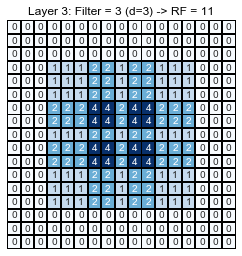

In [6]:
receptive_field_filter(n=17, f=3, s=1, L=3, d=[1,1,3])